<a href="https://colab.research.google.com/github/daferocu/Topicos-Avanzados/blob/main/datalab/Proyecto%202/P1_MovieGenrePrediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification**

**Proyecto Procesamiento de Lenguaje Natural - NLP**

**Profesor:** Sergio Alberto Mora Pardo

**Integrantes:**

*   Daniel Rodríguez
*   Diana Ibáñez
*   Oscar Correcha
*   Erika Cárdenas
*   Paola Castro


**Objetivo:**
Clasificar el género de la película según su trama.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

*Input:*
- movie plot

*Output:*
Probability of the movie belong to each genre


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [1]:
# Instalar librerías requeridas
import os
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords') # Descargar la lista de palabras comunes (stopwords) en varios idiomas que se consideran poco informativas en el análisis de texto.
nltk.download('punkt') # Descarga los modelos y datos necesarios para la tokenización del texto.
nltk.download('wordnet')  # Para lemmatization

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Input
from keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **1. Adquisición de los datos**

In [2]:
# Leer archivos .csv con el dataset para entrenamiento y validación
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [3]:
# Explorar las dimensiones del dataset de entrenamiento
dataTraining.shape

(7895, 5)

In [4]:
# Descripción de los datos en el dataset de entrenamiento
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [5]:
# Ver primeros registros del dataset de validación
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
# Explorar las dimensiones del dataset de validación
dataTesting.shape

(3383, 3)

In [7]:
# Descripción de los datos en el dataset de validación
dataTesting.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3383 entries, 1 to 11275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    3383 non-null   int64 
 1   title   3383 non-null   object
 2   plot    3383 non-null   object
dtypes: int64(1), object(2)
memory usage: 105.7+ KB


In [8]:
# Identificar duplicados y eliminarlos
dataTraining = dataTraining.drop_duplicates()
dataTraining.shape

(7894, 5)

In [9]:
dataTesting = dataTesting.drop_duplicates()
dataTesting.shape

(3383, 3)

### Definir *df_y_genres*

In [10]:
# Definir y
y = dataTraining['genres'].map(lambda x: eval(x))
# Convertir y en un dataframe
y_genres = y.to_frame()
y_genres = y_genres.reset_index()
y_genres.head()

,index,genres
0,3107,"[Short, Drama]"
1,900,"[Comedy, Crime, Horror]"
2,6724,"[Drama, Film-Noir, Thriller]"
3,4704,[Drama]
4,2582,"[Action, Crime, Thriller]"


In [11]:
# Convertir la lista de etiquetas con el género de la película en una representación binaria.
# Se evidencia que una película puede estar asociada a más de un género
le = MultiLabelBinarizer()
df_y_genres = le.fit_transform(y_genres['genres'])
df_y_genres = pd.DataFrame(df_y_genres, columns=le.classes_)
df_y_genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# Explorar las dimensiones del dataframe para y
df_y_genres.shape

(7894, 24)

## **Exploración de los datos**

### Análisis univariado

<Axes: xlabel='year', ylabel='Count'>

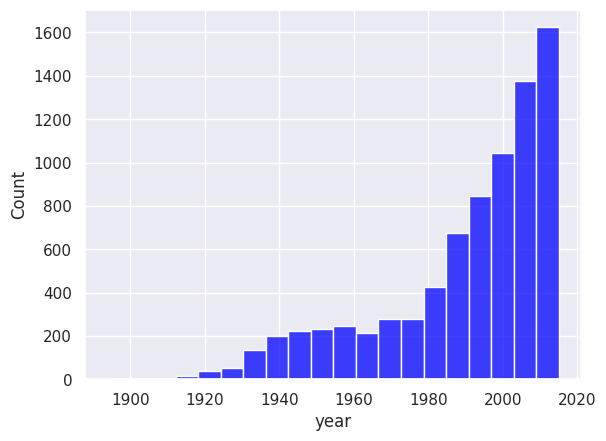

In [13]:
# Análisis univariado de 'year'
sns.histplot(data=dataTraining, x='year',binwidth=6.0, color='blue' )

Asimétrico a la derecha o sesgo positivo, significa que se filmaron más películas en los últimos 30 años.

<ipython-input-14-a954a6d2b331>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_genres.values, y=sorted_classes, palette='plasma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

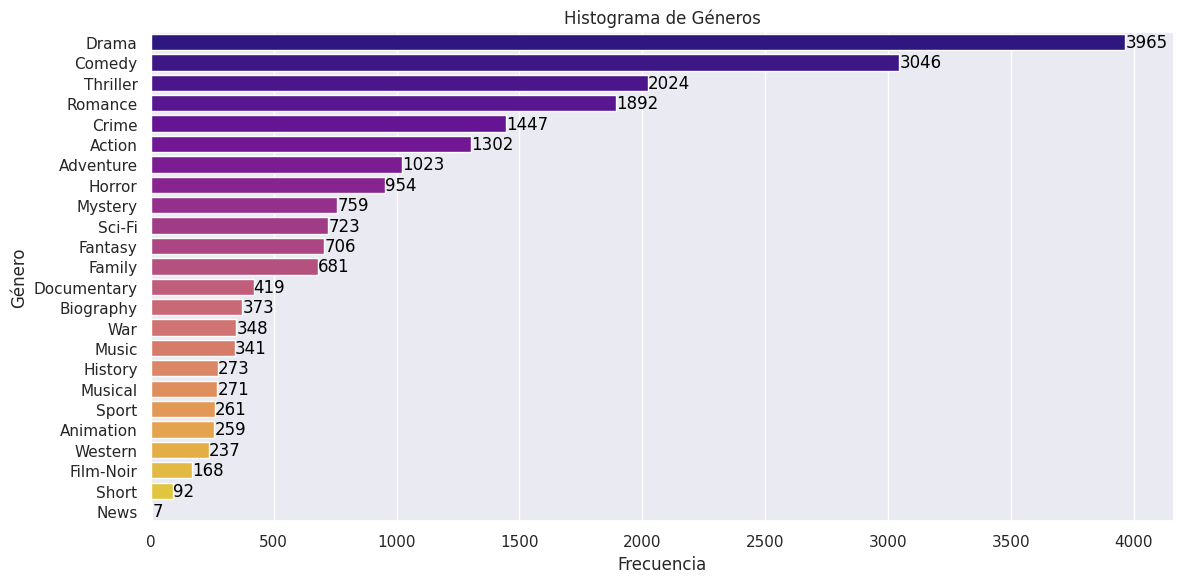

In [14]:
# Análisis univariado de 'genres' (multiclase)
genre_counts = df_y_genres.sum(axis=0)

plt.figure(figsize=(12, 6))
sorted_genres = genre_counts.sort_values(ascending=False)
sorted_classes = sorted_genres.index

ax = sns.barplot(x=sorted_genres.values, y=sorted_classes, palette='plasma')
plt.title('Histograma de Géneros')
plt.xlabel('Frecuencia')
plt.ylabel('Género')

# Añadir etiquetas de datos en las barras
for i, count in enumerate(sorted_genres.values):
    y_pos = min(count + 10, max(sorted_genres.values) + 20)
    ax.text(count, i, str(count), ha='left', va='center', color='black')

plt.tight_layout()
plt.show()

La mayoría de las películas son de Drama y Comedia. Lo que menos hay en el dataset son Cortos y Noticias.

<Axes: xlabel='rating', ylabel='Count'>

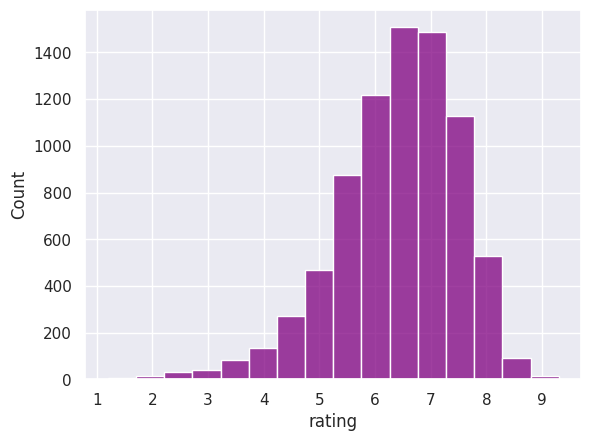

In [15]:
# Análisis univariado de 'rating'
sns.histplot(data=dataTraining, x='rating',binwidth=0.5, color='purple' )

Se observa que la mayoría de las películas tienen evaluación entre 6 y 8.

### Análisis multivariado de '*genres*' (multiclase)

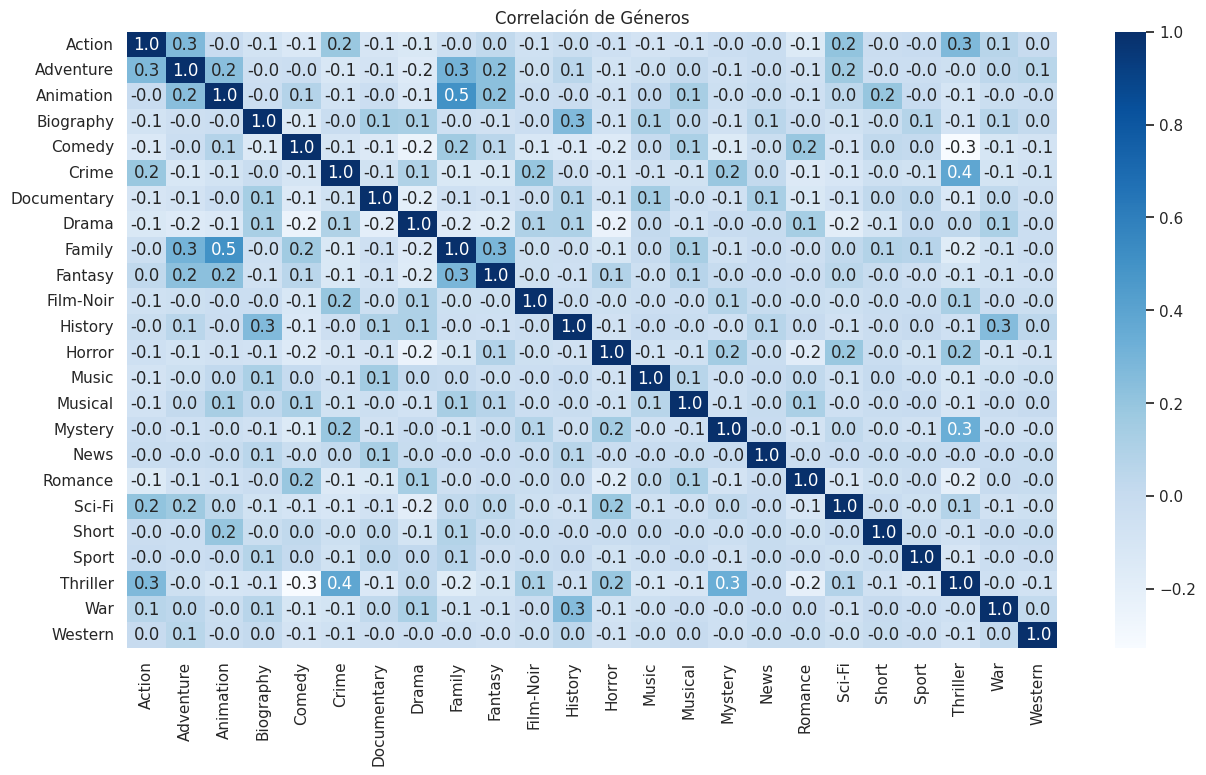

In [16]:
correlation_matrix = df_y_genres.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".1f")
plt.title('Correlación de Géneros')
plt.show()

Mayor correlación positiva entre '*Family*' y '*Animation*' = 0.5

Mayor correlación negativa entre '*Triller*' y '*Comedy*' = -0.3

# **2. Limpieza de texto**

*   De acuerdo con la salida anterior para "dataTraining. info()" y para "dataTesting.info()", no hay valores nulos o faltantes en estos datasets.
*   Antes de la sección "Definir_y_genres", se identificaron y eliminaron los registros duplicados: Hay una película duplicada en dataTraining. En dataTesting no hay duplicados.

# **3. Preprocesamiento de texto**

In [17]:
# Función para quitar stopwords
def quitar_stopwords(texto):
    texto_tokenizado = word_tokenize(texto)  # Tokenizar el texto
    stop_words = set(stopwords.words('english')) # Cargar stopwords en inglés
    return [palabra for palabra in texto_tokenizado if palabra not in stop_words]

# Función para aplicar stemming
#def stemming(texto):
    #stemmer = SnowballStemmer('english')
    #texto_stemming = [stemmer.stem(palabra) for palabra in texto]
    #return texto_stemming

#Función para aplicar lematización
#lemmatizer = WordNetLemmatizer()
#def lemmatization(texto):
    #texto_lemmatizado = [lemmatizer.lemmatize(palabra) for palabra in texto]
    #return texto_lemmatizado

# Función para procesar el texto
def procesamiento(texto):
    texto = texto.lower() # Convertir texto a minúsculas
    texto = re.sub(r'[^a-zA-Z0-9]', ' ', texto) # Remover caracteres que no sean letras ni números, remueve signos de puntuación y reemplazar por un espacio, antes de tokenizar
    texto_sinStopwords = quitar_stopwords(texto)  # Remover stop words
    #texto_conStemming = stemming(texto_sinStopwords) # Stemming de las palabras
    #texto_conLemmatizer = lemmatization(texto_sinStopwords) # Lematización de las palabras
    texto_limpio = ' '.join(texto_sinStopwords) # Unir los tokens nuevamente en texto
    return texto_limpio

**EXPERIMENTO CON USE EMBEDDING Y COMBINACIÓN DE FEATURES 'year' y 'rating'**

In [18]:
# Aplicar preprocesamiento de texto definido a la data de entrenamiento
dataTraining["plot_limpio"] = dataTraining["plot"].apply(procesamiento)
dataTraining_limpio = dataTraining.drop(columns=['title', 'plot', 'genres'])
dataTraining_limpio.reset_index(drop=True, inplace=True)
dataTraining_limpio.head()

,year,rating,plot_limpio
0,2003,8.0,story single father takes eight year old son w...
1,2008,5.6,serial killer decides teach secrets satisfying...
2,1941,7.2,sweden female blackmailer disfiguring facial s...
3,1954,7.4,friday afternoon new york president tredway co...
4,1990,6.6,los angeles editor publishing house carol hunn...


# **4. Feature Engineering**

## Word Embeddings

In [19]:
# Cargar el módulo de Universal Sentence Encoder- USE entrenado por Google, versión 4
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
embedding_USE = hub.load(module_url)  # Devuelve tensores de TensorFlow, no arreglos de NumPy

# Convertir la columna 'plot_limpio' a un string (pq así lo recibe USE)
plot_limpio_embedding = dataTraining_limpio['plot_limpio'].astype(str).tolist()

# Aplicar el modelo Universal Sentence Encoder
embedding = embedding_USE(plot_limpio_embedding)

# Convertir el embedding a un DataFrame de pandas
dataTraining_embedding = pd.DataFrame(embedding.numpy())

dataTraining_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.035446,0.001752,-0.036129,0.024121,-0.055628,0.005528,0.048921,0.044221,0.033820,0.047145,...,-0.042520,-0.061870,-0.017248,0.001525,0.061481,-0.028943,0.037314,-0.017393,0.042126,-0.026759
1,0.032737,-0.011181,-0.053252,-0.060973,0.019451,-0.063125,-0.021590,0.019101,0.016270,-0.076205,...,0.052517,0.050220,-0.015796,0.051881,0.041357,-0.022359,-0.059664,-0.011514,0.055075,0.022161
2,-0.064145,-0.045873,-0.066512,-0.018359,-0.035958,0.044013,-0.001500,0.045311,0.039621,-0.062757,...,-0.036857,-0.066927,0.025341,-0.035405,0.050374,-0.065126,-0.038702,-0.034184,0.016376,-0.025632
3,0.041604,-0.055229,-0.048972,0.052585,0.030268,-0.003619,0.051931,-0.054386,-0.051507,-0.055200,...,-0.036720,-0.055230,0.053531,0.054499,-0.002422,-0.054785,-0.027058,0.043487,-0.042548,0.054563
4,-0.018604,-0.038982,0.010942,-0.002430,0.044396,-0.058898,0.051900,-0.050740,0.038114,-0.058814,...,0.053198,-0.058823,-0.054896,-0.009418,0.037102,-0.004062,0.048192,0.057499,0.058882,-0.016899


# **5. Modelado**

In [20]:
# Agregar las columnas 'year' y 'rating'
dataTraining_modelar = np.concatenate([dataTraining_embedding, dataTraining[['year', 'rating']].values],axis=1)
print(dataTraining_modelar)

[[ 3.54457088e-02  1.75237760e-03 -3.61288860e-02 ... -2.67590545e-02
   2.00300000e+03  8.00000000e+00]
 [ 3.27370949e-02 -1.11810667e-02 -5.32520562e-02 ...  2.21612975e-02
   2.00800000e+03  5.60000000e+00]
 [-6.41448051e-02 -4.58730385e-02 -6.65120259e-02 ... -2.56315060e-02
   1.94100000e+03  7.20000000e+00]
 ...
 [-2.41835937e-02 -3.82396951e-02  4.49724635e-03 ... -3.56904455e-02
   1.95500000e+03  6.40000000e+00]
 [ 4.89080325e-02 -4.90186214e-02  1.73387546e-02 ...  4.90082949e-02
   1.98200000e+03  7.60000000e+00]
 [-3.70626338e-02 -1.85014959e-02  6.68151230e-02 ...  1.05130449e-02
   2.00900000e+03  6.80000000e+00]]


El año y el rating aportan información valiosa para clasificar los géneros, porque han mejorado el AUC. Puede que algunos géneros tengan más probabilidad de aparecer en ciertos periodos o con ciertos niveles de rating. También, se agrega el título pasándolo por el embedding, pero empeora el AUC.

In [21]:
# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(dataTraining_modelar, df_y_genres, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos divididos
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(5288, 514) (2606, 514) (5288, 24) (2606, 24)


**MultiOutputClassifier**

*Propósito:* Este clasificador se utiliza para problemas de clasificación multietiqueta (multilabel), donde cada instancia (ejemplo) puede pertenecer a múltiples clases simultáneamente. Por ejemplo, en un problema de clasificación de texto, un documento puede estar etiquetado como "deporte" y "salud" al mismo tiempo.

*Funcionamiento:* El MultiOutputClassifier entrena un clasificador por cada etiqueta (o clase) presente en los datos. Para cada etiqueta, crea un modelo independiente y luego hace predicciones para cada uno de esos modelos. El resultado es que cada instancia puede ser clasificada en múltiples clases.

## Regresión Logítica


In [22]:
# Entrenar modelo de regresión logística usando MultiOutputClassifier
rl = MultiOutputClassifier(LogisticRegression(max_iter=2000))
rl.fit(X_train, y_train)

# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_genres = rl.predict_proba(X_train)

# Calcular el AUC en el conjunto de entrenamiento
auc_rl_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred_genres[i][:, 1]) for i in range(y_train.shape[1])])

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_genres = rl.predict_proba(X_test)

# Calcular el AUC en el conjunto de prueba
auc_rl_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred_genres[i][:, 1]) for i in range(y_test.shape[1])])

# Ver resultados
print(f"AUC en el conjunto de entrenamiento: {auc_rl_train:.4f}")
print(f"AUC en el conjunto de prueba: {auc_rl_test:.4f}")

# Evaluar si hay sobreajuste
if auc_rl_train - auc_rl_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC en el conjunto de entrenamiento: 0.9317
AUC en el conjunto de prueba: 0.9014
No se detecta sobreajuste significativo.


In [23]:
# Crear un DataFrame vacío para almacenar los resultados
df_resultados = pd.DataFrame(columns=['Modelo', 'AUC_Test', 'AUC_Train'])

# Agregar el resultado al DataFrame de resultados
nombre_modelo_1 = 'Logistic Regression'

# Crear un nuevo DataFrame con el resultado
nuevo_resultado = pd.DataFrame({'Modelo': [nombre_modelo_1], 'AUC_Test': [auc_rl_test], 'AUC_Train': [auc_rl_train]})

# Concatenar el nuevo resultado al DataFrame existente
df_resultados = pd.concat([df_resultados, nuevo_resultado], ignore_index=True)

# Mostrar el DataFrame de resultados
print(df_resultados)


                Modelo  AUC_Test  AUC_Train
0  Logistic Regression  0.901413    0.93171


<ipython-input-23-52674a664684>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, nuevo_resultado], ignore_index=True)


## Random Forest Classifier

Se incluye el parámetro class_weight='balanced' de scikit-learn, para manejar el desbalanceo de las clases a predecir, calculando automáticamente los pesos inversamente proporcionales a las frecuencias de las clases en los datos. Esto significa que las clases con menos instancias obtendrán un peso mayor, mientras que las clases con más instancias obtendrán un peso menor. Este ajuste ayuda a que el clasificador preste más atención a las instancias de la clase minoritaria durante el proceso de entrenamiento. Como resultado, puede mejorar la capacidad del modelo para predecir correctamente las clases menos representadas.

In [24]:
# Entrenar modelo de Random Forest usando MultiOutputClassifier
rf = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_leaf_nodes=5, class_weight='balanced', random_state=42))
rf.fit(X_train, y_train)

# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_genres = rf.predict_proba(X_train)

# Calcular el AUC en el conjunto de entrenamiento
auc_rf_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred_genres[i][:, 1]) for i in range(y_train.shape[1])])

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_genres = rf.predict_proba(X_test)

# Calcular el AUC en el conjunto de prueba
auc_rf_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred_genres[i][:, 1]) for i in range(y_test.shape[1])])

# Ver resultados
print(f"AUC en el conjunto de entrenamiento: {auc_rf_train:.4f}")
print(f"AUC en el conjunto de prueba: {auc_rf_test:.4f}")

# Evaluar si hay sobreajuste
if auc_rf_train - auc_rf_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")


AUC en el conjunto de entrenamiento: 0.9222
AUC en el conjunto de prueba: 0.8720
Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.


In [25]:
# Agregar el resultado al DataFrame de resultados
nombre_modelo_2 = 'Random Forest'

# Crear un nuevo DataFrame con el resultado
nuevo_resultado = pd.DataFrame({'Modelo': [nombre_modelo_2], 'AUC_Test': [auc_rf_test], 'AUC_Train': [auc_rf_train]})

# Concatenar el nuevo resultado al DataFrame existente
df_resultados = pd.concat([df_resultados, nuevo_resultado], ignore_index=True)

# Mostrar el DataFrame de resultados
print(df_resultados)


                Modelo  AUC_Test  AUC_Train
0  Logistic Regression  0.901413   0.931710
1        Random Forest  0.872027   0.922219


## XGBoost

Si el modelo Random Forest tiene un rendimiento muy bajo.
Bagging se recomienda si hay overfitting en el modelo Ramdom Forest.

In [26]:
# Entrenar modelo de XGBoost usando MultiOutputClassifier
xg = MultiOutputClassifier(XGBClassifier(n_jobs=-1, learning_rate=0.01, random_state=42))
xg.fit(X_train, y_train)

# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_genres = xg.predict_proba(X_train)

# Calcular el AUC en el conjunto de entrenamiento
auc_xg_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred_genres[i][:, 1]) for i in range(y_train.shape[1])])

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_genres = xg.predict_proba(X_test)

# Calcular el AUC en el conjunto de prueba
auc_xg_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred_genres[i][:, 1]) for i in range(y_test.shape[1])])

# Ver resultados
print(f"AUC en el conjunto de entrenamiento: {auc_xg_train:.4f}")
print(f"AUC en el conjunto de prueba: {auc_xg_test:.4f}")

# Evaluar si hay sobreajuste
if auc_xg_train - auc_xg_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")


AUC en el conjunto de entrenamiento: 0.9857
AUC en el conjunto de prueba: 0.8512
Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.


In [27]:
# Agregar el resultado al DataFrame de resultados
nombre_modelo_3 = 'XGBoost'

# Crear un nuevo DataFrame con el resultado
nuevo_resultado = pd.DataFrame({'Modelo': [nombre_modelo_3], 'AUC_Test': [auc_xg_test], 'AUC_Train': [auc_xg_train]})

# Concatenar el nuevo resultado al DataFrame existente
df_resultados = pd.concat([df_resultados, nuevo_resultado], ignore_index=True)

# Mostrar el DataFrame de resultados
print(df_resultados)

                Modelo  AUC_Test  AUC_Train
0  Logistic Regression  0.901413   0.931710
1        Random Forest  0.872027   0.922219
2              XGBoost  0.851250   0.985749


## LSTM

In [28]:
# Redimensionar X_train_scaled y X_test_scaled para que sean 3D
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # time_step = 1
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Verificar la nueva forma
print(X_train_reshaped.shape, X_test_reshaped.shape)

(5288, 1, 514) (2606, 1, 514)


In [29]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# Entrenar el modelo
model.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_test_reshaped, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - AUC: 0.5510 - loss: 0.5926 - val_AUC: 0.7441 - val_loss: 0.3286
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.7084 - loss: 0.3367 - val_AUC: 0.7807 - val_loss: 0.3006
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - AUC: 0.7548 - loss: 0.3105 - val_AUC: 0.7855 - val_loss: 0.2968
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7627 - loss: 0.3062 - val_AUC: 0.7863 - val_loss: 0.2962
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7696 - loss: 0.3052 - val_AUC: 0.7868 - val_loss: 0.2962
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7729 - loss: 0.3021 - val_AUC: 0.7869 - val_loss: 0.2961
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7751 - loss: 0.3017 - val_AUC: 0.7871 - val_loss: 0.2961
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7710 - loss: 0.3041 - val_AUC: 0.7873 - val_loss: 0.2965
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

In [30]:
# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_genres = model.predict(X_train_reshaped)

# Calcular el AUC en el conjunto de entrenamiento
auc_rn_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred_genres[:, i]) for i in range(y_train.shape[1])])

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_genres = model.predict(X_test_reshaped)

# Calcular el AUC en el conjunto de prueba
auc_rn_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred_genres[:, i]) for i in range(y_test.shape[1])])

# Ver resultados
print(f"AUC en el conjunto de entrenamiento: {auc_rn_train:.4f}")
print(f"AUC en el conjunto de prueba: {auc_rn_test:.4f}")

# Evaluar si hay sobreajuste
if auc_rn_train - auc_rn_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC en el conjunto de entrenamiento: 0.5465
AUC en el conjunto de prueba: 0.5424
No se detecta sobreajuste significativo.


In [31]:
# Agregar el resultado al DataFrame de resultados
nombre_modelo_4 = 'Redes Neuronales LSTM'

# Crear un nuevo DataFrame con el resultado
nuevo_resultado = pd.DataFrame({'Modelo': [nombre_modelo_4], 'AUC_Test': [auc_rn_test], 'AUC_Train': [auc_rn_train]})

# Concatenar el nuevo resultado al DataFrame existente
df_resultados = pd.concat([df_resultados, nuevo_resultado], ignore_index=True)

# Mostrar el DataFrame de resultados
print(df_resultados)

                  Modelo  AUC_Test  AUC_Train
0    Logistic Regression  0.901413   0.931710
1          Random Forest  0.872027   0.922219
2                XGBoost  0.851250   0.985749
3  Redes Neuronales LSTM  0.542434   0.546452


# **6. Evaluación**

In [32]:
# Mostrar el DataFrame con los resultados del AUC por Modelo
df_resultados = df_resultados.sort_values(by='AUC_Test', ascending=False)
df_resultados

,Modelo,AUC_Test,AUC_Train
0,Logistic Regression,0.901413,0.931710
1,Random Forest,0.872027,0.922219
2,XGBoost,0.851250,0.985749
3,Redes Neuronales LSTM,0.542434,0.546452


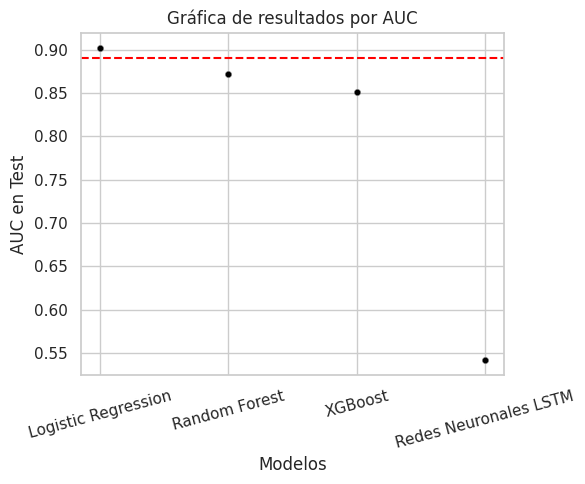

In [34]:
# Gráfica de resultados
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_resultados, x='Modelo', y='AUC_Test', s=20, edgecolor = "gray", color="black")
plt.axhline(y=0.89, color='red', linestyle='--', label='Umbral de éxito AUC = 0,89')
plt.title('Gráfica de resultados por AUC')
plt.xlabel('Modelos')
plt.ylabel('AUC en Test')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()